In [1]:
import pandas as pd
from sklearn.model_selection import learning_curve,train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('D:/kaggle/credit_default/UCI_Credit_Card.csv')
data.shape
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [3]:
#查看下个月违约率情况
next_month=data['default.payment.next.month'].value_counts()
next_month

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [4]:
df=pd.DataFrame({'default.payment.next.month':next_month.index,'values':next_month.values})
plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文 标签

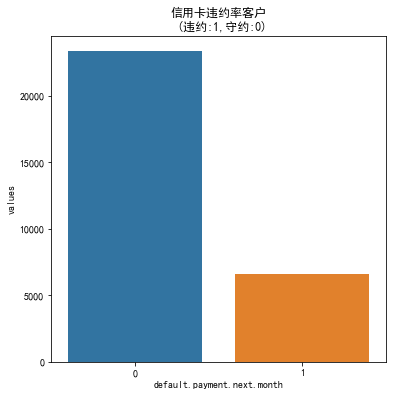

In [5]:
plt.figure(figsize=(6,6))
plt.title('信用卡违约率客户\n (违约:1,守约:0)')
sns.set_color_codes('pastel')
sns.barplot(x='default.payment.next.month',y='values',data=df)

In [6]:
#特征选择，去掉ID字段、最后一个结果字段
data.drop(['ID'],inplace=True,axis=1)
target=data['default.payment.next.month'].values
columns=data.columns.tolist()
columns.remove('default.payment.next.month')
features=data[columns].values

In [7]:
#30%作为测试集，其余为训练集
train_x,test_x,train_y,test_y=train_test_split(features,target,test_size=0.3,stratify=target,random_state=1)

In [8]:
#构造各种分类器
classifiers=[
    SVC(random_state=1,kernel='rbf'),
    DecisionTreeClassifier(random_state=1,criterion='gini'),
    RandomForestClassifier(random_state=1,criterion='gini'),
    KNeighborsClassifier(metric='minkowski'),
]

In [9]:
#分类器名称
classifier_names=[
    'svc',
    'decisiontreeclassifier',
    'randomforestclassifier',
    'kneighborsclassifier',
]

In [10]:
#分类器参数
classifier_param_grid=[
    {'svc__C':[1],'svc__gamma':[0.01]},
    {'decisiontreeclassifier__max_depth':[6,9,11]},
    {'randomforestclassifier__n_estimators':[3,5,6]},
    {'kneighborsclassifier__n_neighbors':[4,6,8]},
]

In [11]:
#对具体的分类器进行GridSearchCV参数调优
def GridSearchCV_work(pipeline,train_x,train_y,test_x,test_y,param_grid,score='accuracy'):
    response={}
    gridsearch=GridSearchCV(estimator=pipeline,param_grid=param_grid,scoring=score)
    #寻找最优的参数和最优的准确率分数
    search=gridsearch.fit(train_x,train_y)
    print('GridSearchCV最优参数:',search.best_params_)
    print('GridSearchCV最优分数: %.4lf' %search.best_score_)
    predict_y=gridsearch.predict(test_x)
    print('准确率 %.4lf' %accuracy_score(test_y,predict_y))
    response['predict_y']=predict_y
    response['accuracy_score']=accuracy_score(test_y,predict_y)
    return response

In [12]:
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid , score = 'accuracy')

GridSearchCV最优参数: {'svc__C': 1, 'svc__gamma': 0.01}
GridSearchCV最优分数: 0.8174
准确率 0.8172
GridSearchCV最优参数: {'decisiontreeclassifier__max_depth': 6}
GridSearchCV最优分数: 0.8186
准确率 0.8113
GridSearchCV最优参数: {'randomforestclassifier__n_estimators': 6}
GridSearchCV最优分数: 0.7998
准确率 0.7994
GridSearchCV最优参数: {'kneighborsclassifier__n_neighbors': 8}
GridSearchCV最优分数: 0.8040
准确率 0.8036
